### Util

In [1]:
import pandas as pd
import numpy as np
from scipy import interp
#import matplotlib.pyplot as plt
import os

from IPython.display import Image
import pydotplus
import graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split,cross_val_score,cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, roc_auc_score,roc_curve, auc, brier_score_loss
from sklearn import tree
import xgboost as xgb
from xgboost import XGBClassifier
from itertools import cycle

import keras
import tensorflow as tf
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Embedding
from tensorflow.keras import backend as K

import lightgbm


Bad key savefig.frameon in file C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
Y

In [2]:
from sklearn.metrics import roc_auc_score
def y_roc(estimator,X):
    y_scores=[]
    for list in estimator.predict_proba(X):
        y_scores.append(list[1])
    return y_scores
def y_roc_regression(estimator,X):
    y_scores=[]
    for list in estimator.predict(X):
        y_scores.append(list)
    return y_scores
def cv_roc_plot(estimator,X,y):
    cv = StratifiedKFold(n_splits=4,shuffle=False)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for train,test in cv.split(X,y):
        prediction = estimator.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
        tpr[0]=0
        tpr[-1]=1
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc
def brier_score(y_prob_raw,y_true):
    y_prob=[prob[1] for prob in y_prob_raw]
    if len(y_prob)!=len(y_true):
        print('Error: two lists must have same length')
        return
    out = 0
    for prob_1,y in zip(y_prob,y_true):
        out+=(prob_1-y)**2
    return out/len(y_prob)
def get_prob_1(y_prob_raw):
    return [prob[1] for prob in y_prob_raw]
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n

### PUMA related data

In [3]:
# All features are available
raw_train=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
raw_train=raw_train.drop(raw_train[raw_train.Recidivism_Arrest_Year1==True].index)
raw_train.columns

Index(['ID', 'Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
     

In [4]:
data_PUMA=pd.read_csv(r'.\data\ss13hga_13.csv')
pdata_PUMA=pd.read_csv(r'.\data\ss13pga_13.csv')
data_PUMA['Code']=None
pdata_PUMA['Code']=None
data_PUMA['PUMA']=data_PUMA['PUMA'].astype(str)
pdata_PUMA['PUMA']=pdata_PUMA['PUMA'].astype(str)
PUMA_code_map={'1003':1,'4400':1,'1008':2,'4300':2,'1200':3, '1300':3,'1400':4,'1500':4,'1600':4,'1700':5,'1800':5,
              '2001':6,'2002':6,'2003':6,'4005':6,'100':7,'200':7,'500':7,'4000':8,'4100':8,'4200':8,'5001':9,'6001':9,'6002':9,
              '2400':10,'5002':10,'1001':11,'3004':11,'4600':11,'1002':12, '1005':12, '3300':12, '3400':12, '4001':12, '4002':12,
              '4006':12,'3101':13,'3102':13,'1900':14, '3900':14, '4003':14, '4004':14,'3001':15, '3002':15, '3003':15, '3005':15,
              '2500':16, '4500':16,'2800':17, '2900':17, '3200':17, '3500':17,'600':18, '700':18, '800':18,'900':19, '1100':19,
              '300':20, '401':20, '402':20, '1004':21, '2100':21 ,'2200':22, '2300':22, '1006':23, '1007':23, '2004':23,'2600':24, 
              '2700':24,'3600':25, '3700':25, '3800':25}
data_PUMA['Code']=data_PUMA['PUMA'].map(PUMA_code_map)
pdata_PUMA['Code']=pdata_PUMA['PUMA'].map(PUMA_code_map)
data_PUMA

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,Code
0,H,127,5,1400,3,13,1000000,1007549,139,1,...,242,41,124,132,224,157,237,280,142,4
1,H,131,5,700,3,13,1000000,1007549,60,3,...,95,96,19,70,53,12,61,18,111,18
2,H,136,5,2200,3,13,1000000,1007549,22,1,...,7,23,33,40,38,19,33,19,8,22
3,H,151,5,1100,3,13,1000000,1007549,213,2,...,55,175,62,53,313,200,330,252,239,19
4,H,294,5,3400,3,13,1000000,1007549,64,2,...,59,19,61,109,102,99,74,73,97,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45693,H,1492766,5,5002,3,13,1000000,1007549,69,1,...,60,95,23,114,81,64,126,67,99,10
45694,H,1492793,5,100,3,13,1000000,1007549,53,2,...,132,51,60,106,39,77,57,49,79,7
45695,H,1492802,5,700,3,13,1000000,1007549,48,2,...,53,59,80,40,68,85,76,105,43,18
45696,H,1492814,5,2800,3,13,1000000,1007549,109,2,...,84,114,101,79,35,203,117,108,182,17


In [5]:
Law_enforcement=pd.read_excel(r'.\data\table_80_full_time_law_enforcement_employees_georgia_by_metropolitan_and_nonmetropolitan_counties_2012.xls')
crime_rates=pd.read_excel(r'.\data\georgia crime rates.xlsx',header=1)
crime_rates=crime_rates.groupby(by='County').sum().iloc[11:,:]
crime_len=pd.merge(Law_enforcement,crime_rates,left_on='County',right_on='County')
crime_len=crime_len.drop(columns=crime_len.columns[crime_len.isnull().any()])
crime_len

,County,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft
0,Barrow,190,129,61,2,33,20,302,547,1551,145
1,Bartow,234,197,37,0,13,32,329,806,2263,264
2,Bibb,361,296,65,19,67,296,416,2500,6297,715
3,Brantley,43,19,24,0,1,7,16,191,243,10
4,Brooks,51,22,29,2,2,9,45,114,291,31
...,...,...,...,...,...,...,...,...,...,...,...
120,Webster,6,5,1,0,0,1,0,8,7,3
121,White,73,40,33,0,3,4,35,153,328,15
122,Wilcox,16,10,6,0,5,2,16,72,93,10
123,Wilkes,27,14,13,0,0,0,32,29,106,11


In [6]:
crime_len=crime_len.set_index(keys='County')
crime_len['PUMA']=None
crime_len.loc['Barrow','PUMA']=3800
crime_len.loc['Bartow','PUMA']=2900
crime_len.loc['Bibb','PUMA']=1700
crime_len.loc['Bryan','PUMA']=200
crime_len.loc['Brooks','PUMA']=700
crime_len.loc['Butts','PUMA']=1900
crime_len.loc['Brantley','PUMA']=500
crime_len.loc['Carroll','PUMA']=2300
crime_len.loc['Catoosa','PUMA']=2600
crime_len.loc['Chatham','PUMA']=401
crime_len.loc['Chattahoochee','PUMA']=1700
crime_len.loc['Cherokee','PUMA']=3101
crime_len.loc['Clarke','PUMA']=3600
crime_len.loc['Clayton','PUMA']=5001
crime_len.loc['Cobb','PUMA']=3001
crime_len.loc['Columbia','PUMA']=4100
crime_len.loc['Coweta','PUMA']=2100
crime_len.loc['Dade','PUMA']=2600
crime_len.loc['Dawson','PUMA']=3200
crime_len.loc['Dougherty','PUMA']=900
crime_len.loc['Effingham','PUMA']=300
crime_len.loc['Floyd','PUMA']=2500
crime_len.loc['Forsyth','PUMA']=3300
crime_len.loc['Fulton','PUMA']=4600
crime_len.loc['Glynn','PUMA']=100
crime_len.loc['Hall','PUMA']=3400
crime_len.loc['Haralson','PUMA']=2500
crime_len.loc['Harris','PUMA']=1800
crime_len.loc['Heard','PUMA']=2200
crime_len.loc['Henry','PUMA']=600
crime_len.loc['Houston','PUMA']=1500
crime_len.loc['Jones','PUMA']=1600
crime_len.loc['Lamar','PUMA']=1900
crime_len.loc['Lanier','PUMA']=500
crime_len.loc['Long','PUMA']=200
crime_len.loc['Lowndes','PUMA']=600
crime_len.loc['Madison','PUMA']=3700
crime_len.loc['McDuffie','PUMA']=4200
crime_len.loc['McIntosh','PUMA']=100
crime_len.loc['Morgan','PUMA']=3900
crime_len.loc['Monroe','PUMA']=1600
crime_len.loc['Oconee','PUMA']=3700
crime_len.loc['Oglethorpe','PUMA']=3700
crime_len.loc['Pickens','PUMA']=2800
crime_len.loc['Spalding','PUMA']=1900
crime_len.loc['Twiggs','PUMA']=1600
crime_len.loc['Appling','PUMA']=1200
crime_len.loc['Baldwin','PUMA']=1600
crime_len.loc['Ben Hill','PUMA']=700
crime_len.loc['Berrien','PUMA']=700
crime_len.loc['Newton','PUMA']=4300
crime_len.loc['Paulding','PUMA']=4500
crime_len.loc['Pulaski','PUMA']=1500
crime_len.loc['Rockdale','PUMA']=4300
crime_len.loc['Walker','PUMA']=2600
crime_len.loc['Walton','PUMA']=3900
crime_len.loc['Whitfield','PUMA']=2700
crime_len.loc['Worth','PUMA']=800
crime_len.loc['Bulloch','PUMA']=300
crime_len.loc['Camden','PUMA']=100
crime_len.loc['Chattooga','PUMA']=2600
crime_len.loc['Decatur','PUMA']=2002
crime_len.loc['Dodge','PUMA']=1300
crime_len.loc['Dooly','PUMA']=2600
crime_len.loc['Early','PUMA']=1100
crime_len.loc['Elbert','PUMA']=3700
crime_len.loc['Emanuel','PUMA']=1300
crime_len.loc['Fannin','PUMA']=2800
crime_len.loc['Franklin','PUMA']=3500
crime_len.loc['Gilmer','PUMA']=2800
crime_len.loc['Gordon','PUMA']=2800
crime_len.loc['Grady','PUMA']=1100
crime_len.loc['Greene','PUMA']=3300
crime_len.loc['Habersham','PUMA']=3500
crime_len.loc['Hancock','PUMA']=4200
crime_len.loc['Hart','PUMA']=3500
crime_len.loc['Irwin','PUMA']=1600
crime_len.loc['Jackson','PUMA']=1900
crime_len.loc['Jefferson','PUMA']=4200
crime_len.loc['Bleckley','PUMA']=1300
crime_len.loc['Charlton','PUMA']=500
crime_len.loc['Clinch','PUMA']=500
crime_len.loc['Coffee','PUMA']=500
crime_len.loc['Cook','PUMA']=700
crime_len.loc['Crisp','PUMA']=1800
crime_len.loc['Johnson','PUMA']=1300
crime_len.loc['Lumpkin','PUMA']=1800
crime_len.loc['Miller','PUMA']=1100
crime_len.loc['Mitchell','PUMA']=1100
crime_len.loc['Miller','PUMA']=1100
crime_len.loc['Pierce','PUMA']=500
crime_len.loc['Polk','PUMA']=2500
crime_len.loc['Rabun','PUMA']=3200
crime_len.loc['Schley','PUMA']=1800
crime_len.loc['Seminole','PUMA']=1100
crime_len.loc['Stephens','PUMA']=3500
crime_len.loc['Stewart','PUMA']=200
crime_len.loc['Sumter','PUMA']=1800
crime_len.loc['Talbot','PUMA']=1800
crime_len.loc['Taliaferro','PUMA']=4200
crime_len.loc['Taylor','PUMA']=1800
crime_len.loc['Tift','PUMA']=700
crime_len.loc['Towns','PUMA']=3200
crime_len.loc['Treutlen','PUMA']=1300
crime_len.loc['Upson','PUMA']=1900
crime_len.loc['Macon','PUMA']=1400
crime_len.loc['Polk','PUMA']=2500
crime_len.loc['Screven','PUMA']=300
crime_len.loc['Thomas','PUMA']=800
crime_len.loc['Troup','PUMA']=2200
crime_len.loc['Union','PUMA']=1004
crime_len.loc['Ware','PUMA']=500
crime_len.loc['Warren','PUMA']=4200
crime_len.loc['Washington','PUMA']=4200
crime_len.loc['Wayne','PUMA']=1200
crime_len.loc['Webster','PUMA']=1800
crime_len.loc['White','PUMA']=3200
crime_len.loc['Wilcox','PUMA']=1300
crime_len.loc['Wilkes','PUMA']=4200
crime_len.loc['Wilkinson','PUMA']=1600
crime_len.drop(index=crime_len[crime_len.PUMA.isnull()].index,inplace=True)
crime_len['Code']=(crime_len['PUMA']).astype(str).map(PUMA_code_map)
crime_len=crime_len.astype(int)
crime_len=crime_len.groupby('Code').mean()
crime_len.reset_index(inplace=True)

In [7]:
PUMA_group=data_PUMA.groupby(by='Code',as_index=False).mean()
PUMA_group=PUMA_group.iloc[:,:-81].drop(columns=['SERIALNO', 'DIVISION', 'REGION', 'ST', 'ADJHSG', 'ADJINC',
       'WGTP'])
PUMA_group['TEN']=data_PUMA[['Code','TEN']].groupby(by='Code',as_index=False).agg(lambda x:x.value_counts().index[0])['TEN']
PUMA_new=pd.merge(PUMA_group,crime_len,left_on='Code',right_on='Code',how='outer')
PUMA_new=PUMA_new.fillna(PUMA_new.mean())

In [8]:
raw_extend=pd.merge(raw_train,PUMA_new,left_on='Residence_PUMA',right_on='Code',how='left')

# Change the dtype of the feature from object to intagar
raw_extend['TEN']=raw_extend['TEN'].astype('category')
raw_extend['TEN']=raw_extend['TEN'].cat.codes
raw_extend['Residence_PUMA']=raw_extend['Residence_PUMA'].astype('category')
raw_extend['Residence_PUMA']=raw_extend['Residence_PUMA'].cat.codes
raw_extend['Age_at_Release']=raw_extend['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_extend['Dependents']=raw_extend['Dependents'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Arrest_Episodes_Felony']=raw_extend['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Drug']=raw_extend['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Misd']=raw_extend['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Violent']=raw_extend['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_Property']=raw_extend['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Arrest_Episodes_PPViolationCharges']=raw_extend['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_extend['Prior_Conviction_Episodes_Felony']=raw_extend['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Misd']=raw_extend['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Prop']=raw_extend['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_extend['Prior_Conviction_Episodes_Drug']=raw_extend['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_extend['Delinquency_Reports']=raw_extend['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_extend['Program_Attendances']=raw_extend['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_extend['Program_UnexcusedAbsences']=raw_extend['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_extend['Residence_Changes']=raw_extend['Residence_Changes'].apply(lambda x: int(x[:1]))

scaler = StandardScaler()
scaling_set=[]
for column in raw_extend.columns:
    if raw_extend[column].dtype == object:
        raw_extend[column]=raw_extend[column].astype('category')
        raw_extend[column]=raw_extend[column].cat.codes
    elif raw_extend[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_extend[scaling_set]=scaler.fit_transform(raw_extend[scaling_set].values)

Logistic regression train score: 0.7465219224283305 
 test score: 0.7420170723996206 
 Logistic regression train Brier score: 0.17236565921948835 
 test Brier score: 0.1753431584611295 
 AUROC: 0.6857945758726021
Random forest train score: 1.0 
 test score: 0.7473917167246286 
 Random forest  train Brier score: 0.024640289488476238 
 test Brier score: 0.17694515052517001 
 AUROC: 0.6623156384596705
SGD best layer size: {'min_samples_split': 4, 'n_estimators': 100} 
 best train score: -0.1709255324726474 
 test score: -0.1697356918297213 
 SGD  train Brier score: 0.15192509009585523 
 test Brier score: 0.16973569182972115 
 AUROC: 0.7105305479936438
Epoch 1/200


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


208/208 [==============================] - 1s 2ms/step - loss: 0.7403 - accuracy: 0.6058 - val_loss: 0.5624 - val_accuracy: 0.7446
Epoch 2/200
208/208 [==============================] - 0s 1ms/step - loss: 0.6300 - accuracy: 0.7038 - val_loss: 0.5596 - val_accuracy: 0.7446
Epoch 3/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5938 - accuracy: 0.7247 - val_loss: 0.5586 - val_accuracy: 0.7446
Epoch 4/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5827 - accuracy: 0.7341 - val_loss: 0.5592 - val_accuracy: 0.7446
Epoch 5/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5771 - accuracy: 0.7360 - val_loss: 0.5597 - val_accuracy: 0.7446
Epoch 6/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5733 - accuracy: 0.7381 - val_loss: 0.5589 - val_accuracy: 0.7446
Epoch 7/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5698 - accuracy: 0.7377 - val_loss: 0.5564 - val_accuracy: 0.7446
Epoch 8/200

208/208 [==============================] - 0s 1ms/step - loss: 0.5380 - accuracy: 0.7399 - val_loss: 0.5289 - val_accuracy: 0.7475
Epoch 59/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5385 - accuracy: 0.7409 - val_loss: 0.5281 - val_accuracy: 0.7482
Epoch 60/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5339 - accuracy: 0.7410 - val_loss: 0.5278 - val_accuracy: 0.7482
Epoch 61/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.7407 - val_loss: 0.5280 - val_accuracy: 0.7492
Epoch 62/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5372 - accuracy: 0.7412 - val_loss: 0.5280 - val_accuracy: 0.7453
Epoch 63/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5380 - accuracy: 0.7392 - val_loss: 0.5281 - val_accuracy: 0.7457
Epoch 64/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5336 - accuracy: 0.7413 - val_loss: 0.5272 - val_accuracy: 0.7478
Epoch

Epoch 115/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5281 - accuracy: 0.7396 - val_loss: 0.5239 - val_accuracy: 0.7453
Epoch 116/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5285 - accuracy: 0.7387 - val_loss: 0.5244 - val_accuracy: 0.7450
Epoch 117/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5293 - accuracy: 0.7413 - val_loss: 0.5239 - val_accuracy: 0.7478
Epoch 118/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5294 - accuracy: 0.7421 - val_loss: 0.5237 - val_accuracy: 0.7475
Epoch 119/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5270 - accuracy: 0.7406 - val_loss: 0.5237 - val_accuracy: 0.7464
Epoch 120/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5254 - accuracy: 0.7404 - val_loss: 0.5232 - val_accuracy: 0.7468
Epoch 121/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5250 - accuracy: 0.7402 - val_loss: 0.5234 - val_ac

208/208 [==============================] - 0s 1ms/step - loss: 0.5226 - accuracy: 0.7422 - val_loss: 0.5221 - val_accuracy: 0.7460
Epoch 172/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5238 - accuracy: 0.7433 - val_loss: 0.5211 - val_accuracy: 0.7464
Epoch 173/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5219 - accuracy: 0.7401 - val_loss: 0.5212 - val_accuracy: 0.7485
Epoch 174/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5216 - accuracy: 0.7436 - val_loss: 0.5213 - val_accuracy: 0.7496
Epoch 175/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5195 - accuracy: 0.7416 - val_loss: 0.5220 - val_accuracy: 0.7485
Epoch 176/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.7442 - val_loss: 0.5217 - val_accuracy: 0.7503
Epoch 177/200
208/208 [==============================] - 0s 1ms/step - loss: 0.5236 - accuracy: 0.7430 - val_loss: 0.5218 - val_accuracy: 0.7471

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.1704436991851747 
 test Brier score: 0.17458438374543317 
 AUROC: 0.6817159362498882
Xgboost best layer size: {'colsample_bytree': 0.8, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'reg_lambda': 1000, 'subsample': 0.9} 
 best train score: -0.17219113427738023 
 test score: -0.1695792168784868 
 Xgboost train Brier score: 0.16168550375104063 
 test Brier score: 0.16957921690116723 
 AUROC: 0.7101540499895624


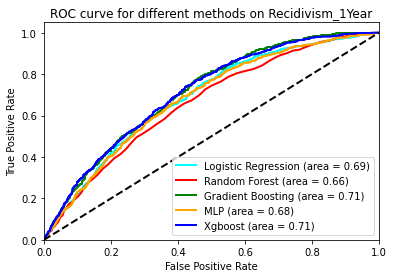

In [9]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend['Recidivism_Arrest_Year2'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150,100],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD, scoring='neg_brier_score',cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_child_weight': [2,4,6],
    'subsample': [0.9],
    'colsample_bytree': [0.8],'reg_lambda':[1000]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB, scoring='neg_brier_score',cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

In [10]:
GBDT_importance=pd.DataFrame()
GBDT_importance['Feature']=raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1).columns
GBDT_importance['importance']=grid_SGD.best_estimator_.feature_importances_
GBDT_importance=GBDT_importance.sort_values(by='importance',ascending=False)
GBDT_importance

,Feature,importance
45,Percent_Days_Employed,0.186335
46,Jobs_Per_Year,0.146400
16,Prior_Arrest_Episodes_PPViolationCharges,0.071115
2,Age_at_Release,0.069156
4,Gang_Affiliated,0.062296
...,...,...
96,YBL,0.000000
95,WATP,0.000000
94,VEH,0.000000
93,VALP,0.000000


In [14]:
GBDT_importance.tail(11)

,Feature,importance
103,FSMOCP,0.0
102,FPARC,0.0
101,FINCP,0.0
99,FGRNTP,0.0
98,FFINCP,0.0
97,FES,0.0
96,YBL,0.0
95,WATP,0.0
94,VEH,0.0
93,VALP,0.0


In [15]:
GBDT_importance[GBDT_importance.importance==0]

,Feature,importance
187,FVALP,0.0
146,FBUSP,0.0
145,FBROADBNDP,0.0
185,FTOILP,0.0
138,WORKSTAT,0.0
...,...,...
96,YBL,0.0
95,WATP,0.0
94,VEH,0.0
93,VALP,0.0


In [12]:
raw_extend_remove=raw_extend.drop(list(GBDT_importance[GBDT_importance.importance==0].Feature),axis=1)
raw_extend_remove=raw_extend_remove.drop(columns=['PUMA'])

logistic_t regression train score: 0.7474704890387859 
 test score: 0.7413847613025608 
 logistic_t regression train Brier score: 0.17316677698794947 
 test Brier score: 0.1733842314181451 
 AUROC: 0.7061798958415116
Random forest train score: 1.0 
 test score: 0.7407524502055011 
 Random forest  train Brier score: 0.024287961401535964 
 test Brier score: 0.17402142832051218 
 AUROC: 0.702015126534244
SGD best layer size: {'min_samples_split': 4, 'n_estimators': 100} 
 best train score: -0.17000461902078176 
 test score: -0.16864156061796565 
 SGD  train Brier score: 0.1525993611187537 
 test Brier score: 0.16864156061796584 
 AUROC: 0.7300798199471356
Epoch 1/200


C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


208/208 [==============================] - 1s 3ms/step - loss: 0.7816 - accuracy: 0.6138 - val_loss: 0.5570 - val_accuracy: 0.7482
Epoch 2/200
208/208 [==============================] - 0s 2ms/step - loss: 0.6229 - accuracy: 0.6916 - val_loss: 0.5526 - val_accuracy: 0.7492
Epoch 3/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5940 - accuracy: 0.7198 - val_loss: 0.5504 - val_accuracy: 0.7496
Epoch 4/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.7336 - val_loss: 0.5493 - val_accuracy: 0.7492
Epoch 5/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.7366 - val_loss: 0.5490 - val_accuracy: 0.7489
Epoch 6/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7378 - val_loss: 0.5482 - val_accuracy: 0.7499
Epoch 7/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.7401 - val_loss: 0.5481 - val_accuracy: 0.7496
Epoch 8/200

208/208 [==============================] - 0s 2ms/step - loss: 0.5357 - accuracy: 0.7443 - val_loss: 0.5234 - val_accuracy: 0.7464
Epoch 59/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.7419 - val_loss: 0.5239 - val_accuracy: 0.7471
Epoch 60/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5369 - accuracy: 0.7413 - val_loss: 0.5237 - val_accuracy: 0.7471
Epoch 61/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5345 - accuracy: 0.7395 - val_loss: 0.5247 - val_accuracy: 0.7492
Epoch 62/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5374 - accuracy: 0.7415 - val_loss: 0.5231 - val_accuracy: 0.7475
Epoch 63/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5374 - accuracy: 0.7434 - val_loss: 0.5228 - val_accuracy: 0.7457
Epoch 64/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5341 - accuracy: 0.7458 - val_loss: 0.5232 - val_accuracy: 0.7468
Epoch

Epoch 115/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.7389 - val_loss: 0.5202 - val_accuracy: 0.7460
Epoch 116/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5314 - accuracy: 0.7425 - val_loss: 0.5204 - val_accuracy: 0.7475
Epoch 117/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5305 - accuracy: 0.7431 - val_loss: 0.5211 - val_accuracy: 0.7443
Epoch 118/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5287 - accuracy: 0.7436 - val_loss: 0.5209 - val_accuracy: 0.7489
Epoch 119/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.7446 - val_loss: 0.5208 - val_accuracy: 0.7464
Epoch 120/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5289 - accuracy: 0.7439 - val_loss: 0.5209 - val_accuracy: 0.7464
Epoch 121/200
208/208 [==============================] - 0s 2ms/step - loss: 0.5294 - accuracy: 0.7430 - val_loss: 0.5208 - val_ac

C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
C:\Users\myjr\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:4

MLP train Brier score: 0.17112599446814658 
 test Brier score: 0.17388917553753533 
 AUROC: 0.7044222867760592
Xgboost best layer size: {'colsample_bytree': 0.8, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'reg_lambda': 1000, 'subsample': 0.9} 
 best train score: -0.17122557885284376 
 test score: -0.16920286951037405 
 Xgboost train Brier score: 0.16209568199803753 
 test Brier score: 0.16920286941518003 
 AUROC: 0.7280128758734395


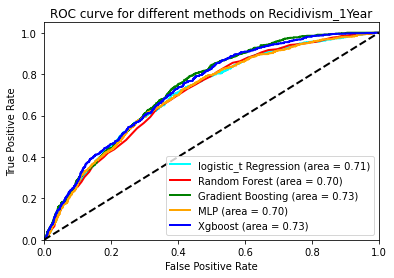

In [13]:
from sklearn.linear_model import LinearRegression,LogisticRegression


X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend_remove.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic_t=LogisticRegression(max_iter=1000)
logistic_t.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic_t,X_test1.fillna(0)))
print('logistic_t regression train score:',
      logistic_t.score(X_train1.fillna(0),y_train1),'\n test score:',logistic_t.score(X_test1.fillna(0),y_test1.fillna(0)),'\n logistic_t regression train Brier score:',
      brier_score(logistic_t.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic_t.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic_t,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150,100],'min_samples_split':[2,4]}
grid_SGD_t=GridSearchCV(GBDT,param_grid=params_SGD, scoring='neg_brier_score',cv=3)
grid_SGD_t.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD_t.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD_t.best_params_,'\n best train score:',
      grid_SGD_t.best_score_,'\n test score:',grid_SGD_t.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD_t.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD_t.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD_t.best_estimator_,X_test1.fillna(0))))

pipe_t = Sequential()
n_cols = X_train1.shape[1]
pipe_t.add(BatchNormalization(input_shape=(n_cols,)))
pipe_t.add(Dense(70, activation= 'linear'))
pipe_t.add(Dropout(0.3))
pipe_t.add(Dense(50, activation= 'relu'))
pipe_t.add(Dropout(0.3))
pipe_t.add(Dense(50, activation= 'relu'))
pipe_t.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe_t.add(BatchNormalization())
pipe_t.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe_t.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe_t.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe_t.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe_t.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe_t,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe_t.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe_t.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe_t,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_child_weight': [2,4,6],
    'subsample': [0.9],
    'colsample_bytree': [0.8],'reg_lambda':[1000]}
grid_XGB_t=GridSearchCV(XGB,param_grid=params_XGB, scoring='neg_brier_score',cv=3)
grid_XGB_t.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB_t.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB_t.best_params_,'\n best train score:',
      grid_XGB_t.best_score_,'\n test score:',grid_XGB_t.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB_t.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB_t.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB_t.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['logistic_t Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

### Year2 Recidivism
When training, we need to discard those who recommit crime in 1st year.

In [9]:
from sklearn.linear_model import LinearRegression,LogisticRegression
raw_extend_year2=raw_extend_remove.drop(raw_extend_remove[raw_extend_remove.Recidivism_Arrest_Year1==True].index)

X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend_year2.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_year2['Recidivism_Arrest_Year2'])
fpr_list,tpr_list,auc_list=dict(),dict(),dict()


logistic=LogisticRegression(max_iter=1000)
logistic.fit(X_train1.fillna(0),y_train1)
fpr_list[0], tpr_list[0], _ = roc_curve(y_test1, y_roc(logistic,X_test1.fillna(0)))
print('Logistic regression train score:',
      logistic.score(X_train1.fillna(0),y_train1),'\n test score:',logistic.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Logistic regression train Brier score:',
      brier_score(logistic.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(logistic.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(logistic,X_test1.fillna(0))))

RF=RandomForestClassifier(n_estimators=150,min_samples_split=2)
RF.fit(X_train1.fillna(0),y_train1)
fpr_list[1], tpr_list[1], _ = roc_curve(y_test1, y_roc(RF,X_test1.fillna(0)))
print('Random forest train score:',
      RF.score(X_train1.fillna(0),y_train1),'\n test score:',RF.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Random forest  train Brier score:',
      brier_score(RF.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(RF.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(RF,X_test1.fillna(0))))

GBDT=GradientBoostingClassifier()
params_SGD={'n_estimators':[150,100],'min_samples_split':[2,4]}
grid_SGD=GridSearchCV(GBDT,param_grid=params_SGD, scoring='neg_brier_score',cv=3)
grid_SGD.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[2], tpr_list[2], _ = roc_curve(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0)))
print('SGD best layer size:',grid_SGD.best_params_,'\n best train score:',
      grid_SGD.best_score_,'\n test score:',grid_SGD.score(X_test1.fillna(0),y_test1.fillna(0)),'\n SGD  train Brier score:',
      brier_score(grid_SGD.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_SGD.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_SGD.best_estimator_,X_test1.fillna(0))))

pipe = Sequential()
n_cols = X_train1.shape[1]
pipe.add(BatchNormalization(input_shape=(n_cols,)))
pipe.add(Dense(70, activation= 'linear'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
pipe.add(Dense(50, activation= 'relu'))
pipe.add(Dropout(0.3))
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(100, activation='linear'))
pipe.add(BatchNormalization())
pipe.add(Dense(2, activation='softmax'))
    #model.compile(
        #optimizer='Adam',
        #loss='mean_squared_error',
        #metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=50)
sgd = keras.optimizers.SGD(lr=.001, decay=2e-4, momentum=0.9, nesterov=True)
pipe.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'sgd', metrics=['accuracy'])
history=pipe.fit(X_train1.fillna(0).astype('float32'), y_train1, validation_split=0.3, epochs=200, callbacks=[early_stopping_monitor])
#history=model.fit(X_train, y_train, validation_split=0.2, epochs=25)
score = pipe.evaluate(X_test1.fillna(0).astype('float32'), y_test1, verbose=0)
pipe.fit(X_train1.fillna(0).astype('float32'),y_train1.fillna(0))
fpr_list[3], tpr_list[3], _ = roc_curve(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32')))
print('MLP train Brier score:',
      brier_score(pipe.predict_proba(X_train1.fillna(0).astype('float32')),y_train1),'\n test Brier score:',brier_score(pipe.predict_proba(X_test1.fillna(0).astype('float32')),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(pipe,X_test1.fillna(0).astype('float32'))))


XGB=XGBClassifier()
params_XGB={    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'min_child_weight': [2,4,6],
    'subsample': [0.9],
    'colsample_bytree': [0.8],'reg_lambda':[1000]}
grid_XGB=GridSearchCV(XGB,param_grid=params_XGB, scoring='neg_brier_score',cv=3)
grid_XGB.fit(X_train1.fillna(0),y_train1.fillna(0))
fpr_list[4], tpr_list[4], _ = roc_curve(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0)))
print('Xgboost best layer size:',grid_XGB.best_params_,'\n best train score:',
      grid_XGB.best_score_,'\n test score:',grid_XGB.score(X_test1.fillna(0),y_test1.fillna(0)),'\n Xgboost train Brier score:',
      brier_score(grid_XGB.predict_proba(X_train1.fillna(0)),y_train1),'\n test Brier score:',brier_score(grid_XGB.predict_proba(X_test1.fillna(0)),y_test1),
     '\n AUROC:',roc_auc_score(y_test1, y_roc(grid_XGB.best_estimator_,X_test1.fillna(0))))



colors = cycle(['aqua', 'red', 'green','orange','blue'])
labels=['Logistic Regression','Random Forest','Gradient Boosting','MLP','Xgboost']
for i, label, color in zip(range(len(fpr_list)), labels, colors):
    legend= label + ' (area = {1:0.2f})'''.format(i, auc(fpr_list[i], tpr_list[i]))
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2,label=legend)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different methods on Recidivism_1Year')
plt.legend(loc="lower right")
plt.savefig('ROC_plot.png',dpi=300)
plt.show()

NameError: name 'raw_extend_remove' is not defined

In [20]:
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n
X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])

X_train1_t,X_test1_t,y_train1_t,y_test1_t=train_test_split(raw_extend_remove.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])

brier_score(aver_prob([grid_SGD_t.best_estimator_.predict_proba(X_test1_t.fillna(0)),
                       grid_SGD.best_estimator_.predict_proba(X_test1.fillna(0)),
                       #grid_XGB_t.best_estimator_.predict_proba(X_test1_t.fillna(0)),
                       grid_XGB.best_estimator_.predict_proba(X_test1.fillna(0)),                       
                       ]),y_test1)

0.17605078595905532

In [21]:
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n
X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])

X_train1_t,X_test1_t,y_train1_t,y_test1_t=train_test_split(raw_extend_remove.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])

brier_score(aver_prob([grid_SGD_t.best_estimator_.predict_proba(X_test1_t.fillna(0)),
                       grid_SGD.best_estimator_.predict_proba(X_test1.fillna(0)),
                       grid_XGB_t.best_estimator_.predict_proba(X_test1_t.fillna(0)),
                       grid_XGB.best_estimator_.predict_proba(X_test1.fillna(0)),                       
                       ]),y_test1)

0.17137843522146545

In [19]:
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n
X_train1,X_test1,y_train1,y_test1=train_test_split(raw_extend.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])

X_train1_t,X_test1_t,y_train1_t,y_test1_t=train_test_split(raw_extend_remove.drop(['ID','Recidivism_Within_3years','Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'],axis=1),raw_extend_remove['Recidivism_Arrest_Year2'])

brier_score(aver_prob([#grid_SGD_t.best_estimator_.predict_proba(X_test1_t.fillna(0)),
                       grid_SGD.best_estimator_.predict_proba(X_test1.fillna(0)),
                       #grid_XGB_t.best_estimator_.predict_proba(X_test1_t.fillna(0)),
                       grid_XGB.best_estimator_.predict_proba(X_test1.fillna(0)),                       
                       ]),y_test1)

0.15887170588258817

### Test

In [22]:
raw_test=pd.read_csv(r'.\data\NIJ_s_Recidivism_Challenge_Test_Dataset2.csv')
raw_test=pd.merge(raw_test,PUMA_new,left_on='Residence_PUMA',right_on='Code',how='left')
# Change the dtype of the feature from object to intagar
raw_test['TEN']=raw_test['TEN'].astype('category')
raw_test['TEN']=raw_test['TEN'].cat.codes
raw_test['Residence_PUMA']=raw_test['Residence_PUMA'].astype('category')
raw_test['Residence_PUMA']=raw_test['Residence_PUMA'].cat.codes
raw_test['Age_at_Release']=raw_test['Age_at_Release'].apply(lambda x: int(x[:2]))
raw_test['Dependents']=raw_test['Dependents'].apply(lambda x: int(x[:1]))
raw_test['Prior_Arrest_Episodes_Felony']=raw_test['Prior_Arrest_Episodes_Felony'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Drug']=raw_test['Prior_Arrest_Episodes_Drug'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Misd']=raw_test['Prior_Arrest_Episodes_Misd'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Violent']=raw_test['Prior_Arrest_Episodes_Violent'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_Property']=raw_test['Prior_Arrest_Episodes_Property'].apply(lambda x: int(x[:2]))
raw_test['Prior_Arrest_Episodes_PPViolationCharges']=raw_test['Prior_Arrest_Episodes_PPViolationCharges'].apply(lambda x: int(x[:2]))
raw_test['Prior_Conviction_Episodes_Felony']=raw_test['Prior_Conviction_Episodes_Felony'].apply(lambda x: int(x[:1]))
raw_test['Prior_Conviction_Episodes_Misd']=raw_test['Prior_Conviction_Episodes_Misd'].apply(lambda x: int(x[:1]))
raw_test['Prior_Conviction_Episodes_Prop']=raw_test['Prior_Conviction_Episodes_Prop'].apply(lambda x: int(x[:1]))
raw_test['Prior_Conviction_Episodes_Drug']=raw_test['Prior_Conviction_Episodes_Drug'].apply(lambda x: int(x[:1]))
#raw_test['Delinquency_Reports']=raw_test['Delinquency_Reports'].apply(lambda x: int(x[:1]))
#raw_test['Program_Attendances']=raw_test['Program_Attendances'].apply(lambda x: int(x[:2]))
#raw_test['Program_UnexcusedAbsences']=raw_test['Program_UnexcusedAbsences'].apply(lambda x: int(x[:1]))
#raw_test['Residence_Changes']=raw_test['Residence_Changes'].apply(lambda x: int(x[:1]))


raw_test

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Total\nofficers,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft,PUMA
0,6,M,WHITE,38,16,False,5.0,Standard,High School Diploma,0,...,60.230769,18.384615,0.384615,4.615385,5.769231,68.769231,197.769231,587.615385,43.538462,3146.153846
1,8,M,BLACK,38,15,False,5.0,High,High School Diploma,3,...,111.750000,24.000000,1.500000,15.000000,36.750000,158.250000,541.250000,1707.750000,150.750000,3000.000000
2,15,M,WHITE,33,4,False,7.0,Standard,Less than HS diploma,1,...,55.700000,15.700000,2.100000,9.100000,37.900000,72.900000,376.300000,867.800000,82.400000,1780.000000
3,16,M,BLACK,33,2,False,4.0,Standard,Less than HS diploma,3,...,15.750000,16.375000,1.000000,2.125000,7.250000,40.625000,135.875000,357.125000,13.625000,1275.000000
4,23,F,WHITE,48,4,NaN,4.0,NaN,High School Diploma,0,...,55.700000,15.700000,2.100000,9.100000,37.900000,72.900000,376.300000,867.800000,82.400000,1780.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,26740,M,WHITE,48,11,False,5.0,Standard,At least some college,3,...,241.666667,45.666667,2.333333,19.333333,26.666667,101.000000,463.000000,1567.000000,117.000000,3333.333333
5456,26744,M,BLACK,48,20,False,7.0,Standard,Less than HS diploma,0,...,94.000000,40.500000,2.500000,11.000000,25.000000,83.000000,354.500000,984.000000,64.500000,1552.000000
5457,26746,M,BLACK,43,5,False,5.0,Standard,At least some college,3,...,31.000000,5.000000,1.000000,3.000000,9.000000,118.000000,233.000000,592.000000,13.000000,2002.000000
5458,26752,M,BLACK,28,6,False,5.0,Standard,At least some college,3,...,30.153846,24.000000,1.153846,4.923077,16.692308,69.000000,194.461538,579.000000,29.384615,338.461538


In [23]:
#raw_extend_test=pd.merge(raw_test,PUMA_new,left_on='Residence_PUMA',right_on='Code',how='outer')
raw_extend_test=raw_test.copy()
# Change the dtype of the feature from object to intagar

# scale the columns which are not bool or category
scaler = StandardScaler()
scaling_set=[]
for column in raw_extend_test.columns:
    if raw_extend_test[column].dtype == object:
        raw_extend_test[column]=raw_extend_test[column].astype('category')
        raw_extend_test[column]=raw_extend_test[column].cat.codes
    elif raw_extend_test[column].dtype in ['int64','float32','float64'] :
        scaling_set+=[column]
raw_extend_test[scaling_set]=scaler.fit_transform(raw_extend_test[scaling_set].values)
raw_extend_test
#raw_extend_test=raw_extend_test.drop(index=raw_extend_test[raw_extend_test.Supervision_Risk_Score_First.isnull()].index)
#raw_extend_test=raw_extend_test.drop(index=set(raw_extend_test[raw_extend_test.Supervision_Level_First.isnull()].index) & set(raw_extend_test[raw_extend_test.Prison_Offense .isnull()].index))
#raw_extend_test=raw_extend_test.reset_index(drop=True)
# impute missing value 'Supervision_Level_First' and 'Prison_Offense' with relative feature
for missing_column in ['Supervision_Level_First','Prison_Offense']:
    test_index=raw_extend_test[raw_extend_test[missing_column]==-1].index
    train_index=raw_extend_test[raw_extend_test[missing_column]!=-1].index
    X=raw_extend_test.drop(columns=[missing_column])
    y=raw_extend_test[missing_column]
    logreg = LogisticRegression()
    logreg.fit(X.iloc[train_index,:].fillna(0),y[train_index])
    raw_extend_test.loc[test_index,missing_column]=logreg.predict(X.iloc[test_index,:].fillna(0))
    raw_extend_test[missing_column]=raw_extend_test[missing_column].astype('category')
    raw_extend_test[missing_column]=raw_extend_test[missing_column].cat.codes

C:\Users\myjr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\myjr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

In [24]:
raw_extend_test_t=raw_extend_test.drop(list(GBDT_importance[GBDT_importance.importance==0].Feature),axis=1)
raw_extend_test_t

,ID,Gender,Race,Age_at_Release,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,FTELP,FVACSP,FVEHP,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians,Burglary,Larceny,Vehicle Theft,PUMA
0,-1.682777,1,1,0.507782,0,-0.385252,2,1,-1.219910,2,...,0.170101,-0.440234,-0.754932,-0.442168,-0.389742,-0.512988,-0.371568,-0.350737,-0.293308,0.556955
1,-1.682520,1,0,0.507782,0,-0.385252,0,1,1.234595,0,...,3.582757,-1.400531,-0.651192,-0.216168,-0.123506,-0.433774,-0.210058,-0.173294,-0.213081,0.443348
2,-1.681620,1,1,-0.033508,0,0.459367,2,2,-0.401742,3,...,0.000267,-0.262700,0.129668,-0.470708,-0.413155,-0.550859,-0.287621,-0.306352,-0.264228,-0.504963
3,-1.681492,1,0,-0.033508,0,-0.807562,2,2,1.234595,0,...,0.090767,1.752553,0.835333,-0.626063,-0.619605,-0.541337,-0.400672,-0.387249,-0.315693,-0.897502
4,-1.680592,0,1,1.590364,-1,-0.807562,2,1,-1.219910,3,...,0.000267,-0.262700,0.129668,-0.470708,-0.413155,-0.550859,-0.287621,-0.306352,-0.264228,-0.504963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,1.752851,1,1,1.590364,0,-0.385252,2,0,1.234595,0,...,-0.650412,-1.053449,-0.396083,0.383428,0.547864,-0.128131,-0.246853,-0.195590,-0.238336,0.702450
5456,1.753365,1,0,1.590364,0,0.459367,2,2,-1.219910,2,...,-0.862282,0.375927,0.316156,-0.221113,-0.215232,-0.201015,-0.297871,-0.287945,-0.277623,-0.682188
5457,1.753622,1,0,1.049073,0,-0.385252,2,0,1.234595,3,...,-0.014744,-0.895153,0.365913,-0.610735,-0.540798,-0.701799,-0.355002,-0.350042,-0.316161,-0.332401
5458,1.754393,1,0,-0.574799,0,-0.385252,2,0,1.234595,2,...,-0.186956,2.589765,-1.099334,-0.538927,-0.545170,-0.433774,-0.373124,-0.352102,-0.303900,-1.625477


In [27]:
def aver_prob(prob_lists):
    n=len(prob_lists)
    return np.sum(np.array(prob_lists),0)/n
prob_list=aver_prob([[x[1] for x in grid_SGD.best_estimator_.predict_proba(raw_extend_test.drop(['ID'],axis=1).fillna(0))],
          [x[1] for x in grid_XGB.best_estimator_.predict_proba(raw_extend_test.drop(['ID'],axis=1))],
          ])

In [28]:
raw_extend_test['Probability']=prob_list
raw_extend_test['ID']=raw_test.ID
raw_extend_test

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,Total\ncivilians,Murder,Rape,Robbery,Assault,Burglary,Larceny,Vehicle Theft,PUMA,Probability
0,6,1,1,0.507782,16,0,-0.385252,2,1,-1.219910,...,-0.512988,-0.334484,-0.417857,-0.296440,-0.310084,-0.371568,-0.350737,-0.293308,0.556955,0.055036
1,8,1,0,0.507782,15,0,-0.385252,0,1,1.234595,...,-0.433774,-0.291915,-0.194198,-0.252712,-0.193511,-0.210058,-0.173294,-0.213081,0.443348,0.360398
2,15,1,1,-0.033508,4,0,0.459367,2,2,-0.401742,...,-0.550859,-0.269017,-0.321270,-0.251089,-0.304702,-0.287621,-0.306352,-0.264228,-0.504963,0.308977
3,16,1,0,-0.033508,2,0,-0.807562,2,2,1.234595,...,-0.541337,-0.310998,-0.471494,-0.294350,-0.346749,-0.400672,-0.387249,-0.315693,-0.897502,0.278147
4,23,0,1,1.590364,4,-1,-0.807562,2,1,-1.219910,...,-0.550859,-0.269017,-0.321270,-0.251089,-0.304702,-0.287621,-0.306352,-0.264228,-0.504963,0.224093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,26740,1,1,1.590364,11,0,-0.385252,2,0,1.234595,...,-0.128131,-0.260112,-0.100869,-0.266944,-0.268094,-0.246853,-0.195590,-0.238336,0.702450,0.100192
5456,26744,1,0,1.590364,20,0,0.459367,2,2,-1.219910,...,-0.201015,-0.253751,-0.280348,-0.269296,-0.291544,-0.297871,-0.287945,-0.277623,-0.682188,0.041388
5457,26746,1,0,1.049073,5,0,-0.385252,2,0,1.234595,...,-0.701799,-0.310998,-0.452649,-0.291880,-0.245947,-0.355002,-0.350042,-0.316161,-0.332401,0.122643
5458,26752,1,0,-0.574799,6,0,-0.385252,2,0,1.234595,...,-0.433774,-0.305126,-0.411230,-0.281022,-0.309783,-0.373124,-0.352102,-0.303900,-1.625477,0.146249


In [29]:
# Male
Output_male=raw_extend_test[raw_extend_test['Gender']==1][['ID','Gender','Probability']]
Output_male.ID=Output_male.ID.astype(int)
Output_male.Gender='M'
# Female
Output_female=raw_extend_test[raw_extend_test['Gender']==0][['ID','Gender','Probability']]
Output_female.ID=Output_female.ID.astype(int)
Output_female.Gender='F'
Final_out=Output_male.append(Output_female).reset_index(drop=True)
Final_out.to_csv(r'Recidivism_year2.csv',index=False)
Final_out

,ID,Gender,Probability
0,6,M,0.055036
1,8,M,0.360398
2,15,M,0.308977
3,16,M,0.278147
4,27,M,0.266731
...,...,...,...
5455,26543,F,0.060433
5456,26604,F,0.222661
5457,26617,F,0.091506
5458,26622,F,0.116771


In [112]:
Final_out.Probability.isnull().sum()

0